# Khipu demo for ecoli_pos data analysis

- Goal: data analysis on the E. coli data in the khipu paper
- Citation: Li, S. and Zheng, S., 2023. Generalized tree structure to annotate untargeted metabolomics and stable isotope tracing data. Analytical chemistry, 95(15), pp.6212-6217. (https://pubs.acs.org/doi/10.1021/acs.analchem.2c05810)
- Original repo: https://github.com/shuzhao-li-lab/khipu


This notebook is run on $docker run -v /Users/shuzhao/play:/home/jovyan -p 8888:8888 jupyter/scipy-notebook


## Part I. Differential features between 12C and 13C samples

The data contain 6 samples, 3 in each group. We first do a t-test to get features that differ between two groups.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

In [2]:
# demo data are at https://github.com/shuzhao-li/khipu/tree/main/testdata/
# Have a look via pd
ecoli = pd.read_table("ecoli_pos.tsv", index_col=0, sep="\t")
ecoli.head()

,mz,rtime,12C_Ecoli_20220321_004,12C_Ecoli_20220321_004_20220322095030,12C_Ecoli_20220321_004_20220322130235,13C_Ecoli_20220321_004,13C_Ecoli_20220321_004_20220322132355,13C_Ecoli_20220321_004_20220322101150
id_number,,,,,,,,
F1,61.9278,40.94,42543,0,0,43369,60144,57714
F2,95.9735,125.06,2079328,984349,1314348,1707804,1299125,1159692
F3,115.9802,11.42,3362695,3228128,4076328,3201740,3942341,3326312
F4,115.9860,5.83,2035714,1739145,1978764,1977817,2040421,1642861
F5,115.9860,27.96,182603,219669,248607,199092,185630,185255


In [3]:
# t-test of each row between 12C and 13C samples
# data are log2 transformed in this test to have more normal distribution; +1 to avoid log2(0)
def ttest(row):
    t,p = ttest_ind(np.log2(row[3:6]+1), np.log2(row[6:9]+1))
    return p

pvalues_featurelist = ecoli.apply(ttest, axis=1)

In [4]:
# sort p-values
pvalues_featurelist = pvalues_featurelist.sort_values()
pvalues_featurelist.head(10)

id_number
F1039    4.028376e-13
F2201    3.386336e-11
F2955    4.471926e-11
F1417    1.217689e-10
F2675    2.118523e-10
F2784    2.630405e-10
F2663    8.330401e-10
F2930    1.497729e-09
F2874    2.037131e-09
F3182    2.161996e-09
dtype: float64

In [5]:
# how many features have p < 0.001
pvalues_featurelist[pvalues_featurelist<0.001].shape

(73,)

### Summary
We got 73 features in this table that differ between 12C and 13C samples with p < 0.001.

We'll next look at their corresponding compound and intensity across ions and samples.

## Part II. Pre-annotation and plot using khipu

In [6]:
!pip install --upgrade khipu-metabolomics

  Found existing installation: khipu-metabolomics 0.4.16
    Uninstalling khipu-metabolomics-0.4.16:
      Successfully uninstalled khipu-metabolomics-0.4.16


In [7]:
from khipu.extended import *
# after verson 0.5.3
from khipu.plot import plot_khipugram

In [8]:
# One can redefine the patterns
# isotope_search_patterns = isotope_search_patterns[:6]

for x in (adduct_search_patterns, isotope_search_patterns, extended_adducts):
    print(x, '\n')
    

[(21.982, 'Na/H'), (41.026549, 'ACN'), (35.9767, 'HCl'), (37.955882, 'K/H')] 

[(1.003355, '13C/12C', (0, 0.8)), (2.00671, '13C/12C*2', (0, 0.8)), (3.010065, '13C/12C*3', (0, 0.8)), (4.01342, '13C/12C*4', (0, 0.8)), (5.016775, '13C/12C*5', (0, 0.8)), (6.02013, '13C/12C*6', (0, 0.8)), (7.023485, '13C/12C*7', (0, 0.8)), (8.02684, '13C/12C*8', (0, 0.8)), (9.030195, '13C/12C*9', (0, 0.8)), (10.03355, '13C/12C*10', (0, 0.8)), (11.036905, '13C/12C*11', (0, 0.8)), (12.04026, '13C/12C*12', (0, 0.8))] 

[(1.0078, 'H'), (-1.0078, '-H'), (10.991, 'Na/H, double charged'), (0.5017, '13C/12C, double charged'), (117.02655, '-NH3'), (17.02655, 'NH3'), (-18.0106, '-H2O'), (18.0106, 'H2O'), (18.033823, 'NH4'), (27.01089904, 'HCN'), (37.94694, 'Ca/H2'), (32.026215, 'MeOH'), (43.96389, 'Na2/H2'), (67.987424, 'NaCOOH'), (83.961361, 'KCOOH'), (97.96737927, 'H2SO4'), (97.97689507, 'H3PO4')] 



In [9]:
# read data via khipu
peaklist = read_features_from_text(open("ecoli_pos.tsv").read(),
                    id_col=0, mz_col=1, rtime_col=2, intensity_cols=(3, 9), delimiter="\t")

table header looks like:  ['id_number', 'mz', 'rtime', '12C_Ecoli_20220321_004', '12C_Ecoli_20220321_004_20220322095030', '12C_Ecoli_20220321_004_20220322130235', '13C_Ecoli_20220321_004', '13C_Ecoli_20220321_004_20220322132355', '13C_Ecoli_20220321_004_20220322101150']
Read 3602 feature lines


In [10]:
peaklist[55]

{'id': 'F56',
 'mz': 97.1013,
 'rtime': 66.21,
 'intensities': [3138738.0,
  2184196.0,
  1433236.0,
  3032564.0,
  1719115.0,
  1937016.0],
 'representative_intensity': 2240810.8333333335}

In [11]:
khipu_list, all_assigned_peaks = peaklist_to_khipu_list(peaklist, 
                    isotope_search_patterns=isotope_search_patterns, 
                    adduct_search_patterns=adduct_search_patterns,
                    mz_tolerance_ppm=5,
                    rt_tolerance=2, 
                    mode='pos')



Initial khipu search grid: 
                 M+H+       Na/H        HCl        K/H        ACN
M0           1.007276  22.989276  36.983976  38.963158  42.033825
13C/12C      2.010631  23.992631  37.987331  39.966513  43.037180
13C/12C*2    3.013986  24.995986  38.990686  40.969868  44.040535
13C/12C*3    4.017341  25.999341  39.994041  41.973223  45.043890
13C/12C*4    5.020696  27.002696  40.997396  42.976578  46.047245
13C/12C*5    6.024051  28.006051  42.000751  43.979933  47.050600
13C/12C*6    7.027406  29.009406  43.004106  44.983288  48.053955
13C/12C*7    8.030761  30.012761  44.007461  45.986643  49.057310
13C/12C*8    9.034116  31.016116  45.010816  46.989998  50.060665
13C/12C*9   10.037471  32.019471  46.014171  47.993353  51.064020
13C/12C*10  11.040826  33.022826  47.017526  48.996708  52.067375
13C/12C*11  12.044181  34.026181  48.020881  50.000063  53.070730
13C/12C*12  13.047536  35.029536  49.024236  51.003418  54.074085


Warning no match in isotope_pattern:  16.053

In [12]:
len(khipu_list), len(all_assigned_peaks)

(548, 1746)

In [13]:
ksizes = [
    (len(KP.nodes_to_use), KP.id) for KP in khipu_list
]
ksizes = sorted(ksizes, reverse=True)
print(ksizes[:30])

[(30, 'kp31_114.0549'), (20, 'kp33_116.0479'), (16, 'kp90_103.0165'), (15, 'kp11_123.0222'), (13, 'kp132_187.1686'), (11, 'kp259_309.0862'), (10, 'kp93_165.079'), (10, 'kp40_136.0998'), (10, 'kp198_231.1861'), (9, 'kp94_129.1024'), (9, 'kp65_123.0318'), (9, 'kp5_122.084'), (9, 'kp2_71.0008'), (9, 'kp211_236.0834'), (8, 'kp201_174.1007'), (7, 'kp54_97.0985'), (7, 'kp357_233.125'), (7, 'kp284_414.2045'), (7, 'kp139_181.0741'), (7, 'kp135_112.0156'), (7, 'kp10_113.0842'), (7, 'kp100_108.0213'), (6, 'kp309_333.0342'), (6, 'kp308_307.0841'), (6, 'kp29_97.968'), (6, 'kp291_283.8771'), (6, 'kp266_305.0676'), (6, 'kp224_243.0859'), (6, 'kp177_187.8941'), (6, 'kp172_134.037')]


In [14]:
# build two dictionary to use.
# kpdict indexed by khipu ID, fdict indexed by feature ID
kpdict, fdict = {}, {}
for KP in khipu_list:
    kpdict[KP.id] = KP
    for f in KP.nodes_to_use:
        fdict[f] = KP

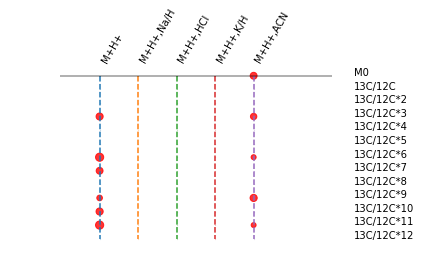

In [15]:
kpdict['kp11_123.0222'].plot()

**Examine the most differential features we got above**

In [16]:
sig = list(pvalues_featurelist[pvalues_featurelist<0.001].index)
print(sig)

['F1039', 'F2201', 'F2955', 'F1417', 'F2675', 'F2784', 'F2663', 'F2930', 'F2874', 'F3182', 'F2178', 'F2633', 'F3024', 'F2931', 'F2338', 'F2923', 'F2863', 'F2132', 'F2979', 'F3078', 'F2343', 'F3009', 'F2421', 'F3042', 'F2924', 'F2706', 'F2727', 'F2653', 'F2514', 'F2716', 'F3181', 'F3180', 'F2720', 'F2695', 'F1843', 'F1703', 'F1691', 'F2422', 'F2667', 'F780', 'F3054', 'F1177', 'F2785', 'F2707', 'F2246', 'F2203', 'F2544', 'F894', 'F1833', 'F2303', 'F1191', 'F2946', 'F3103', 'F2711', 'F3031', 'F3364', 'F2987', 'F2247', 'F65', 'F1495', 'F1690', 'F2950', 'F1496', 'F1894', 'F499', 'F3022', 'F2562', 'F390', 'F3362', 'F1508', 'F2572', 'F3102', 'F3494']


In [17]:
# get khipu IDs for the above features
sig_kps = set([])
for x in sig:
    if x in fdict:
        sig_kps.add( fdict[x].id )

print(len(sig_kps), sig_kps)

25 {'kp232_242.0807', 'kp304_577.5973', 'kp325_206.0694', 'kp259_309.0862', 'kp357_233.125', 'kp216_183.0898', 'kp224_243.0859', 'kp266_305.0676', 'kp366_327.0911', 'kp302_486.3565', 'kp391_365.0897', 'kp371_244.9836', 'kp263_306.5779', 'kp303_577.0978', 'kp240_297.0904', 'kp537_326.0325', 'kp167_156.079', 'kp276_401.0192', 'kp111_146.0691', 'kp469_91.5987', 'kp248_260.1324', 'kp353_202.0414', 'kp279_132.0899', 'kp246_219.9739', 'kp433_419.05'}


In [18]:
# show some sig_kps
sig_kps = list(sig_kps)
for i in sig_kps[:5]:
    print(kpdict[i].id, kpdict[i].neutral_mass)
    print(kpdict[i].khipu_grid)
    print('\n')

kp232_242.0807 242.08066853322998
             M+H+
M0          F3330
13C/12C*11  F2343
13C/12C*12  F2355


kp304_577.5973 577.59734603323
          M+H+ M+H+,13C/12C, double charged
M0       F3010                             
13C/12C  F3022                        F3024


kp325_206.0694 206.06939853323
             M+H+
M0          F3191
13C/12C*10  F1417


kp259_309.0862 309.0862428189443
             M+H+   Na/H HCl K/H ACN
M0                 F3324            
13C/12C                             
13C/12C*2   F2695                   
13C/12C*3                           
13C/12C*4                           
13C/12C*5                           
13C/12C*6   F2729                   
13C/12C*7   F2740                   
13C/12C*8                           
13C/12C*9   F3578  F3004            
13C/12C*10         F3050            
13C/12C*11                          
13C/12C*12                          


kp357_233.125 233.12496553351826
             M+H+ Na/H    HCl    K/H ACN HCl,NH3
M0   

In [19]:
# closer look 
kpdict['kp246_219.9739'].khipu_grid

,M+H+,Na/H,HCl,K/H,ACN,"M+H+,-H2O"
M0,F1483,,,F2496,,F2092
13C/12C,,,,,,
13C/12C*2,,,,,,
13C/12C*3,,,,,,
13C/12C*4,,,,,,
13C/12C*5,,,,F3362,,
13C/12C*6,,,,,,
13C/12C*7,,,,,,
13C/12C*8,,,,,,
13C/12C*9,,,,,,


In [20]:
# m/z view
kpdict['kp246_219.9739'].print3()

,M+H+,Na/H,HCl,K/H,ACN,"M+H+,-H2O"
M0,220.982,,,258.938,,202.971
13C/12C,,,,,,
13C/12C*2,,,,,,
13C/12C*3,,,,,,
13C/12C*4,,,,,,
13C/12C*5,,,,263.953,,
13C/12C*6,,,,,,
13C/12C*7,,,,,,
13C/12C*8,,,,,,
13C/12C*9,,,,,,


In [21]:
for i in sig_kps[10: ]:
    print(kpdict[i].id, kpdict[i].neutral_mass)
    print(kpdict[i].khipu_grid)
    print('\n')

kp391_365.0897 365.08974353323
             M+H+
M0          F3406
13C/12C*12  F2675


kp371_244.9836 244.98358603322998
            M+H+
M0         F3334
13C/12C*5  F2246


kp263_306.5779 306.57791853323
            M+H+
M0         F3567
13C/12C*7  F2716
13C/12C*8  F2722
13C/12C*9  F2732


kp303_577.0978 577.09779603323
          M+H+
M0       F3009
13C/12C  F3019


kp240_297.0904 297.09037103323
             M+H+
M0          F2454
13C/12C*11  F2663


kp537_326.0325 326.03247353323
     M+H+   Na/H M+H+,NH3
M0  F2867  F3103    F3064


kp167_156.079 156.07898886656332
             M+H+ Na/H HCl K/H    ACN
M0          F1628               F1775
13C/12C     F1690                    
13C/12C*2                            
13C/12C*3                            
13C/12C*4                            
13C/12C*5                            
13C/12C*6                            
13C/12C*7                            
13C/12C*8                            
13C/12C*9                            
13C/12C

In [22]:
kpdict['kp224_243.0859'].format_to_epds()

{'interim_id': 'root@243.0859',
 'neutral_formula_mass': 243.0858820335399,
 'neutral_formula': None,
 'Database_referred': [],
 'identity': [],
 'MS1_pseudo_Spectra': [{'id': 'F3331',
   'mz': 244.093,
   'rtime': 27.05,
   'intensities': [3324402.0, 4072782.0, 3961633.0, 0.0, 0.0, 0.0],
   'representative_intensity': 1893136.1666666667,
   'parent_masstrack_id': '244.093',
   'isotope': 'M0',
   'modification': 'M+H+',
   'ion_relation': 'M0,M+H+'},
  {'id': 'F3472',
   'mz': 291.0793,
   'rtime': 27.27,
   'intensities': [0.0, 0.0, 0.0, 553698.0, 1014278.0, 1075498.0],
   'representative_intensity': 440579.0,
   'parent_masstrack_id': '291.0793',
   'isotope': '13C/12C*9',
   'modification': 'K/H',
   'ion_relation': '13C/12C*9,K/H'},
  {'id': 'F2318',
   'mz': 253.1233,
   'rtime': 27.5,
   'intensities': [0.0, 0.0, 0.0, 3996975.0, 4208279.0, 4402969.0],
   'representative_intensity': 2101370.5,
   'parent_masstrack_id': '253.1233',
   'isotope': '13C/12C*9',
   'modification': 'M+

**We can extract sample data from khipu and plot in different ways**

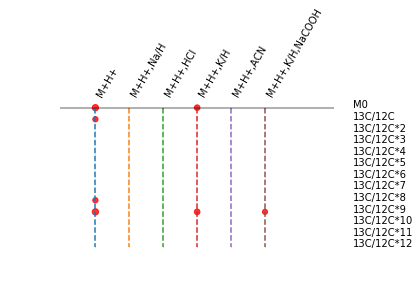

In [23]:
kpdict['kp224_243.0859'].plot()

**Bar plot of average intensity per isotope in M+H+**

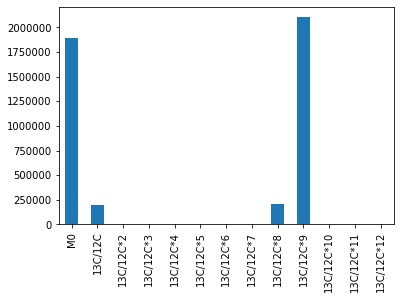

In [24]:
kpdict['kp224_243.0859'].get_khipu_intensities()['M+H+'].plot.bar()

**Bar plot of all 6 samples**

In [25]:
sample_labels = ['12C', '12C', '12C', '13C', '13C', '13C']

In [26]:
def get_sample_data(kp, ion, sample_labels):
    '''kp as khipu instance. Assume sample_labels are in the same order as columns read into khipu instance.
    Return dataframe'''
    data = []
    for ii in range(len(sample_labels)): 
        tmp = [] 
        for f in kp.khipu_grid[ion].values:
            if f:
                tmp.append(kp.feature_dict[f]['intensities'][ii])
            else:
                tmp.append(0)
        data.append(tmp)

    return pd.DataFrame(data, 
                        columns=kp.khipu_grid.index,
                        index=sample_labels,
                        ).T


In [27]:
data = get_sample_data(kpdict['kp224_243.0859'], 'M+H+', sample_labels)
data

,12C,12C,12C,13C,13C,13C
M0,3324402.0,4072782.0,3961633.0,0.0,0.0,0.0
13C/12C,420479.0,355600.0,241481.0,96994.0,0.0,55216.0
13C/12C*2,0.0,0.0,0.0,0.0,0.0,0.0
13C/12C*3,0.0,0.0,0.0,0.0,0.0,0.0
13C/12C*4,0.0,0.0,0.0,0.0,0.0,0.0
13C/12C*5,0.0,0.0,0.0,0.0,0.0,0.0
13C/12C*6,0.0,0.0,0.0,0.0,0.0,0.0
13C/12C*7,0.0,0.0,0.0,0.0,0.0,0.0
13C/12C*8,0.0,0.0,0.0,0.0,526192.0,744605.0
13C/12C*9,0.0,0.0,0.0,3996975.0,4208279.0,4402969.0


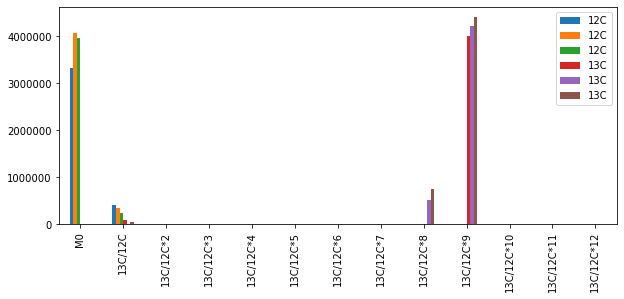

In [28]:
data.plot(kind='bar', stacked=False, figsize=(10, 4))

**The Acetylspermidine example**

In [29]:
fdict['F2353'].khipu_grid

,M+H+,Na/H,HCl,K/H,ACN,"M+H+,Na2/H2"
M0,F2353,F3209,,F3269,,
13C/12C,F1331,,,,,
13C/12C*2,F1397,,,,,
13C/12C*3,F1434,,,,,
13C/12C*4,F1461,,,,,
13C/12C*5,F1507,,,,,
13C/12C*6,F1550,,,,,
13C/12C*7,,,,,,
13C/12C*8,F1685,,,,,F2000
13C/12C*9,F1741,F1454,,F1883,,


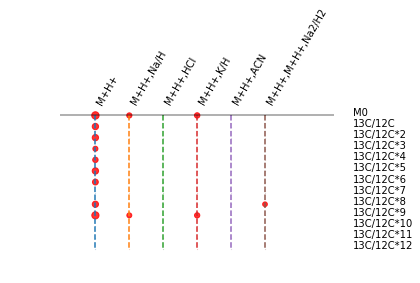

In [30]:
fdict['F2353'].plot()

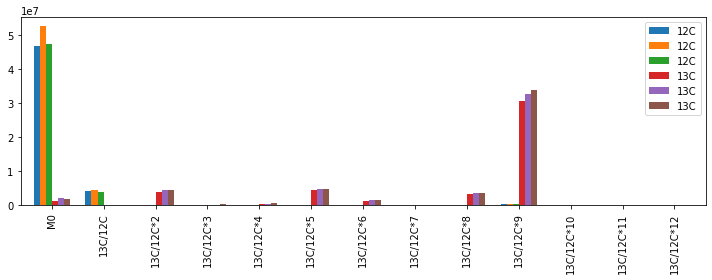

In [31]:
KP2353=fdict['F2353']
data = get_sample_data(KP2353, 'M+H+', sample_labels)
fig = data.plot(kind='bar', stacked=False, width=0.7, figsize=(10, 4))
f = fig.get_figure()
f.tight_layout()
f.savefig('KP2353_samples.pdf')

In [32]:
KP2353.neutral_mass
# HMDB matches to N1 or N8- Acetylspermidine	C9H21N3O	187.1685

187.16862014861462

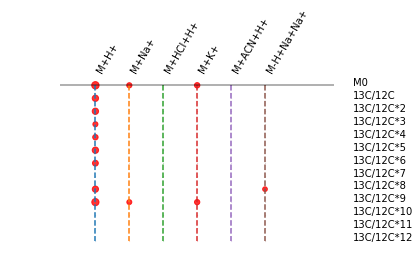

In [35]:
# options to save PDF and replace trunk labels
# one can define own relabel_dict
plot_khipugram(KP2353.get_khipu_intensities(), savepdf='khipugram_F2353.pdf', relabel=relabel_dict)

## Part III. Data formats in khipu and interface with other tools

- khipu exports pre-annotation to two files of JSON and tab delimited formats, this_test.json and this_test.tsv.
- Internal functions and data frames are available to import and use

In [34]:
# check what objects were imported
print([x for x in dir() if x[0]!='_'])

['In', 'KP', 'KP2353', 'Khipu', 'Out', 'PROTON', 'Weavor', 'add_data_to_tag', 'adduct_search_patterns', 'adduct_search_patterns_neg', 'all_assigned_peaks', 'assign_masstrack_ids_in_khipu', 'build_centurion_tree', 'curve_fit', 'data', 'ecoli', 'electron', 'exit', 'export_empCpd_khipu_list', 'export_json_khipu_list', 'export_json_trees', 'export_khipu_table', 'export_tsv_trees', 'extend_khipu_list', 'extended_adducts', 'f', 'fdict', 'fig', 'find_all_matches_centurion_indexed_list', 'find_trees_by_datatag', 'find_trees_by_datatag_list', 'get_adduct_edge_pairs', 'get_ipython', 'get_isotope_pattern_name', 'get_isotopic_edge_pairs', 'get_sample_data', 'graphs_to_khipu_list', 'i', 'is_datatag_in_tree', 'isotope_search_patterns', 'json', 'khipu_annotate', 'khipu_diagnosis', 'khipu_list', 'kpdict', 'ksizes', 'local_read_file', 'make_edge_tag', 'make_expected_adduct_index', 'make_peak_dict', 'make_peak_tag', 'np', 'nx', 'pd', 'peaklist', 'peaklist_to_khipu_list', 'peaks_to_networks', 'plot_khipu

In [36]:
# get documentation on the khipu class
help(KP)

Help on Khipu in module khipu.model object:

class Khipu(builtins.object)
 |  Khipu(subnetwork)
 |  
 |  2-tier tree representation of an empirical compound.
 |  An empTree follows the matrix notion of a family of peaks: a tree of 2 levels - isotopes and adducts.
 |  A true root of khipu is the compound in neutral formula.
 |  A peudo root of khipu is the ion of lowest m/z.
 |  The representative adduct should have the most abundance.
 |  The matrix notion of a khipu is a DataFrame: columns are Adduct labels; rows isotopes.
 |  trunk : default for adducts
 |  branch : default for isotopes
 |  
 |  Methods defined here:
 |  
 |  __init__(self, subnetwork)
 |      Do not include negative m/z difference in this class, as the node of lowest m/z is used as root.
 |      Neutral loss and fragments can be searched after khipu is established.
 |      Input subnetwork is undirected graph, but khipu will require directed graph/tree, by increasing m/z.
 |      subnetwork : undirected graph. Examp

In [37]:
# get documentation on a function, e.g. peaks_to_networks
help(peaks_to_networks)

Help on function peaks_to_networks in module khipu.utils:

peaks_to_networks(peak_list, isotope_search_patterns=[(1.003355, '13C/12C', (0, 0.8)), (2.00671, '13C/12C*2', (0, 0.8)), (3.010065, '13C/12C*3', (0, 0.8)), (4.01342, '13C/12C*4', (0, 0.8)), (5.016775, '13C/12C*5', (0, 0.8)), (6.02013, '13C/12C*6', (0, 0.8))], adduct_search_patterns=[(21.982, 'Na/H'), (41.026549, 'ACN')], mz_tolerance_ppm=5, rt_tolerance=2)
    Search peak_list for patterns of isotopes and adducts, form a network and get connected subnetworks.
    
    Parameters
    ----------
    list_peaks : [{'mz': 133.09702315984987, 'rtime': 654, 'id': 555}, ...]
    
    isotope_search_patterns : exact list used to retrieve the subnetworks. E.g. 
        [ (1.003355, '13C/12C', (0, 0.8)),
        (2.00671, '13C/12C*2', (0, 0.8)),
        (3.010065, '13C/12C*3', (0, 0.8)),
        (4.01342, '13C/12C*4', (0, 0.8)),
        (5.016775, '13C/12C*5', (0, 0.8)),
        (6.02013, '13C/12C*6', (0, 0.8)),]
    
    adduct_search_p

In [38]:
# We have seen the JSON format earlier
fdict['F2353'].format_to_epds()

{'interim_id': 'root@187.1686',
 'neutral_formula_mass': 187.16862014861462,
 'neutral_formula': None,
 'Database_referred': [],
 'identity': [],
 'MS1_pseudo_Spectra': [{'id': 'F1434',
   'mz': 191.1859,
   'rtime': 20.57,
   'intensities': [0.0, 0.0, 0.0, 256261.0, 179058.0, 284038.0],
   'representative_intensity': 119892.83333333333,
   'parent_masstrack_id': '191.1859',
   'isotope': '13C/12C*3',
   'modification': 'M+H+',
   'ion_relation': '13C/12C*3,M+H+'},
  {'id': 'F1507',
   'mz': 193.1927,
   'rtime': 20.81,
   'intensities': [0.0, 0.0, 0.0, 4399053.0, 4835021.0, 4901675.0],
   'representative_intensity': 2355958.1666666665,
   'parent_masstrack_id': '193.1927',
   'isotope': '13C/12C*5',
   'modification': 'M+H+',
   'ion_relation': '13C/12C*5,M+H+'},
  {'id': 'F3269',
   'mz': 226.1318,
   'rtime': 21.54,
   'intensities': [365144.0, 703817.0, 602973.0, 0.0, 0.0, 0.0],
   'representative_intensity': 278655.6666666667,
   'parent_masstrack_id': '226.1318',
   'isotope': 'M

## Summary

Pre-annotation by khipu allow us to use standard data science tools on isotope tracing metabolomics data. 

User can further filter for preferred isotope patterns and apply custom models.